# Toy problem for TLS solution
We want to solve here the identification problem with TLS in a very simple case: a network with 5 nodes, without any structural contraint.
However, we introduce noise in polar coordinates and we try and use the power flow equations written with powers and our covariance matrix estimators in order to weight the noise.

In [1]:
import mlflow
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy import sparse

In [2]:
%load_ext autoreload
%autoreload 2

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import time
import sys
sys.path.insert(1, '..')
from src.models.matrix_operations import vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.simulation.network import cross_multiply_measurements, make_measurements_matrix
from src.models.noise_transformation import power_covariance
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.models.regression import ComplexLasso
from src.identification.error_metrics import fro_error, error_metrics

In [4]:
mlflow.set_experiment('Toy problem with polar noise')

In [5]:
samples = 300
magnitude_sd = 0.01
phase_sd = 0.01
mlflow_params = {'samples': samples, 'magnitude_sd': magnitude_sd, 'phase_sd': phase_sd}

In [6]:
np.random.seed(11)

y_bus = np.array([
    [1+1j, 0, 0, 0, 0],
    [0, 2+1j, 0, 0, 0],
    [2+1j, 0, 1+1j, 0, 0],
    [0, 0, 0, 2+1j, 0],
    [0, 0, 0, 0, -1-1j],
])
nodes = y_bus.shape[0]

real_voltages = np.random.normal(1, 0.1, (samples, nodes)) + 1j*np.random.normal(0, 0.1, (samples, nodes))
real_currents = real_voltages @ y_bus

noisy_voltage = add_polar_noise_to_measurement(real_voltages, magnitude_sd, phase_sd)
noisy_current = add_polar_noise_to_measurement(real_currents, magnitude_sd, phase_sd)

real_powers = np.multiply(real_voltages,real_currents.conj())
powers = np.multiply(noisy_voltage,noisy_current.conj())

real_line_mat = cross_multiply_measurements(real_voltages)
line_mat = cross_multiply_measurements(noisy_voltage)

real_A_mat = make_measurements_matrix(real_voltages)
A_mat = make_measurements_matrix(noisy_voltage)

power_noise = powers - real_powers
line_mat_noise = line_mat - real_line_mat

b_vector = powers.reshape(powers.size)

# Standard TLS

In [7]:
mlflow.start_run(run_name='TLS')
eiv = TotalLeastSquares()
eiv.fit(A_mat, b_vector)
y_eiv = eiv.fitted_admittance_matrix.conj().reshape(5,5)

[[-0.14888447-0.15095446j]]


In [8]:
tls_metrics = error_metrics(y_bus, y_eiv)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(tls_metrics.__dict__)
mlflow.end_run()
tls_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ErrorMetrics(fro_error=0.06796455001017693, max_error=0.030310247135538163, rrms_error=0.014831080714059404, map_error=0.00734558446264526)

# Standard LASSO

In [9]:
mlflow.start_run(run_name='Lasso')
lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-5, 0, 50))
lasso.fit(A_mat, b_vector, True)
y_lasso = lasso.fitted_admittance_matrix.conj().T

In [10]:
lasso_metrics = error_metrics(y_bus, y_lasso)
mlflow.log_param('lambda', lasso.best_trial.hyperparameters['lambda'])
mlflow.log_params(mlflow_params)
mlflow.log_metrics(lasso_metrics.__dict__)
mlflow.end_run()
lasso_metrics

ErrorMetrics(fro_error=0.058626017438657814, max_error=0.025221020325010633, rrms_error=0.012793245838402406, map_error=0.00970611546804615)

In [11]:
lasso.best_trial.hyperparameters

{'lambda': 0.15264179671752334}

# L1-regularized TLS

In [12]:
mlflow.start_run(run_name='S-TLS no cov')
tls_lambda = lasso.best_trial.hyperparameters['lambda']
max_iterations = 50
abs_tol = 10e-12
rel_tol = 10e-12
solver = cp.GUROBI
use_l1_penalty = True
use_cov_matrix = False
sparse_eiv = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv.fit_with_vectored_data(line_mat, A_mat, b_vector)
y_sparse_eiv = sparse_eiv.fitted_admittance_matrix.conj()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


Using license file /Users/jbrouill/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17


In [13]:
stls_metrics = error_metrics(y_bus, y_sparse_eiv)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_eiv.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_metrics

ErrorMetrics(fro_error=0.0227278803987196, max_error=0.015414309574846718, rrms_error=0.004959630110144557, map_error=0.003797078296492107)

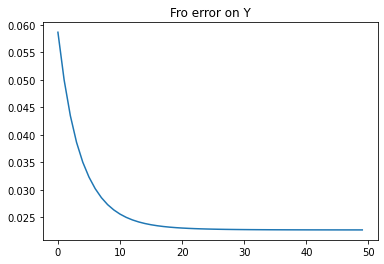

In [14]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


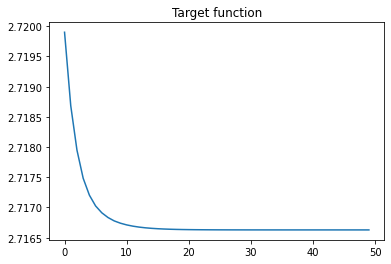

In [15]:
targets.plot(title='Target function');

# L1-regularized TLS with estimated covariance matrix

In [16]:
sigma_power = power_covariance(noisy_voltage.reshape(noisy_voltage.size), noisy_current.reshape(noisy_current.size),
                               magnitude_sd, phase_sd, magnitude_sd, phase_sd)
voltages1 = noisy_voltage.repeat(noisy_voltage.shape[1],1).flatten()
voltages2 = np.tile(noisy_voltage, (1, noisy_voltage.shape[1])).flatten()
sigma_line_mat = power_covariance(voltages1, voltages2, magnitude_sd, phase_sd, magnitude_sd, phase_sd)

inv_sigma_power = sparse.linalg.inv(sigma_power)
inv_sigma_line_mat = sparse.linalg.inv(sigma_line_mat)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
mlflow.start_run(run_name='S-TLS')
use_cov_matrix = True
sparse_eiv_cov = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power)
y_sparse_eiv_cov = sparse_eiv_cov.fitted_admittance_matrix.conj()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
 38%|███▊      | 19/50 [00:05<00:08,  3.52it/s]


In [18]:
stls_cov_metrics = error_metrics(y_bus, y_sparse_eiv_cov)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_cov_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_eiv_cov.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv_cov.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_cov_metrics

ErrorMetrics(fro_error=0.05161291616427047, max_error=0.02073024124977739, rrms_error=0.01126286167429425, map_error=0.005434542529273292)

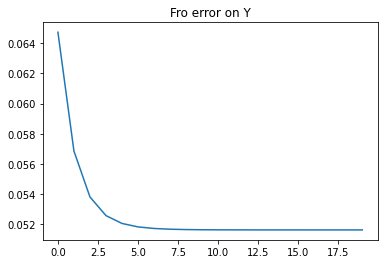

In [19]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


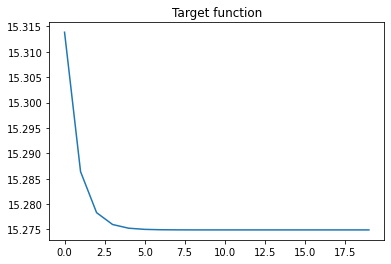

In [20]:
targets.plot(title='Target function');

# L1-regularized TLS with covariance matrix based on actual measurements

In [21]:
sigma_power = power_covariance(real_voltages.reshape(real_voltages.size), real_currents.reshape(real_currents.size),
                               magnitude_sd, phase_sd, magnitude_sd, phase_sd)
voltages1 = real_voltages.repeat(real_voltages.shape[1],1).flatten()
voltages2 = np.tile(real_voltages, (1, real_voltages.shape[1])).flatten()
sigma_line_mat = power_covariance(voltages1, voltages2, magnitude_sd, phase_sd, magnitude_sd, phase_sd)

inv_sigma_power = sparse.linalg.inv(sigma_power)
inv_sigma_line_mat = sparse.linalg.inv(sigma_line_mat)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
mlflow.start_run(run_name='S-TLS')
use_cov_matrix = True
sparse_eiv_cov = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power)
y_sparse_eiv_cov = sparse_eiv_cov.fitted_admittance_matrix.conj()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
 36%|███▌      | 18/50 [00:05<00:09,  3.54it/s]


In [23]:
stls_cov_metrics = error_metrics(y_bus, y_sparse_eiv_cov)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_cov_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_eiv_cov.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv_cov.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_cov_metrics

ErrorMetrics(fro_error=0.051900496852613186, max_error=0.021047285541293044, rrms_error=0.011325616925377013, map_error=0.005430715831364212)

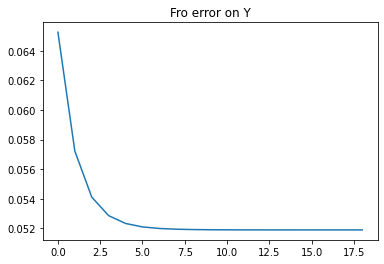

In [24]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


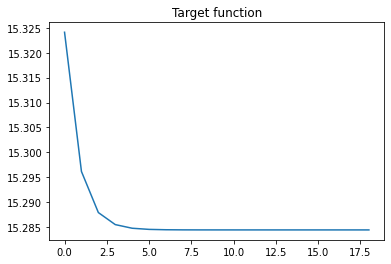

In [25]:
targets.plot(title='Target function');